[<font color='steelblue'>1. - __EDA__</font>](#one-bullet) <br>
    [<font color='steelblue'>1.1. - Imports</font>](#two-bullet) <br>
    [<font color='steelblue'>1.2. - Initial Analysis</font>](#three-bullet) <br>
    [<font color='steelblue'>1.3. - Missing Values</font>](#four-bullet) <br>
    [<font color='steelblue'>1.4. - Feature Engineering</font>](#five-bullet) <br>
    [<font color='steelblue'>1.5. - Outliers</font>](#six-bullet) <br>
    [<font color='steelblue'>1.6. - Cleaning Text</font>](#seven-bullet) <br>

[<font color='steelblue'>2. - __Models__</font>](#eight-bullet) <br>
    [<font color='steelblue'>2.1. - Functions</font>](#nine-bullet) <br>
    [<font color='steelblue'>2.2. - Models</font>](#ten-bullet) <br>
    [<font color='steelblue'>2.3. - PreTrained Models</font>](#eleven-bullet) <br>
    [<font color='steelblue'>2.4. - Results</font>](#twelve-bullet) <br>

Group 7
|Name | Student ID |
|----|----|
|Joana Rodrigues| 20240603|
|Mara Simões| 20240326|
|Matilde Street| 20240523|
|Rafael Silva| 20240511|

<hr>
<a class="anchor" id="one-bullet"> 
<d style="color:white;">

# 1. EDA
</a> 
</d>   

<a class="anchor" id="two-bullet"> 
<d style="color:white;">

## 1.1. Imports
</a> 
</d>   

In [24]:
# Basic utilities for data handling, analysis, and visualization
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Progress bar for loops and long-running processes
from tqdm import tqdm

# Tools for creating visual representations of text
from wordcloud import WordCloud

# Core NLP tools for text cleaning, tokenization, and linguistic processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from textblob import TextBlob
# from langdetect import detect
# from googletrans import Translator

# Machine learning tools for model training, evaluation, and vectorization
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, precision_score, recall_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier

# Word embedding and vectorization using Gensim
from gensim.models import Word2Vec
import gensim.downloader

# Neural networks and deep learning using Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Masking
from tensorflow.keras.utils import to_categorical

# Transformers and pre-trained models from Hugging Face
import torch
from transformers import (
    BertTokenizer, BertModel, RobertaTokenizer, RobertaModel,
    MarianMTModel, MarianTokenizer, pipeline
)

# Additional libraries for advanced modeling and preprocessing
import xgboost as xgb
import fasttext
from imblearn.over_sampling import SMOTE


In [3]:
# to read our data

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train = pd.DataFrame(data=df_train, columns=['text', 'label']).reset_index(drop=True)
df_test = pd.DataFrame(data=df_test, columns=['text', 'label']).reset_index(drop=True)

print(df_train.head())

                                                text  label
0  $BYND - JPMorgan reels in expectations on Beyo...      0
1  $CCL $RCL - Nomura points to bookings weakness...      0
2  $CX - Cemex cut at Credit Suisse, J.P. Morgan ...      0
3  $ESS: BTIG Research cuts to Neutral https://t....      0
4  $FNKO - Funko slides after Piper Jaffray PT cu...      0


In [4]:
# copy of the df to apply in pre-trained models without data cleaning
df_train_raw = df_train.copy()

<a class="anchor" id="three-bullet"> 
<d style="color:white;">

## 1.2. Initial Analysis
</a> 
</d>   

In [5]:
print('Initial dataset contains ', df_train.shape[0], 'rows and ', df_train.shape[1], 'columns')

Initial dataset contains  9543 rows and  2 columns


The dataset contains 3 unique labels to predict.
label
2    6178
1    1923
0    1442
Name: count, dtype: int64


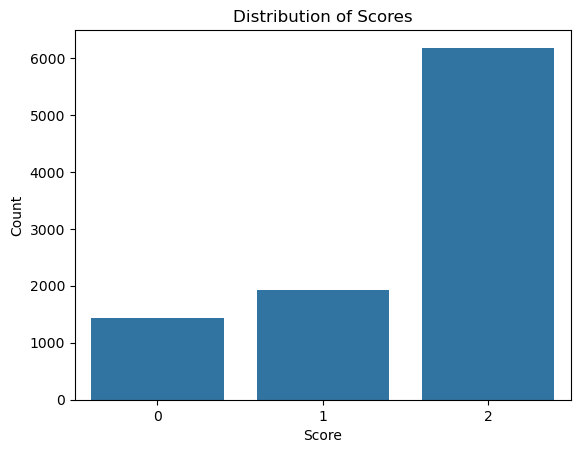

In [6]:
print('The dataset contains', df_train['label'].nunique(), 'unique labels to predict.')
print(df_train['label'].value_counts())

# Visualize distribution of satisfaction
sns.countplot(data=df_train, x='label')
plt.title("Distribution of Scores")
plt.xlabel("Score")
plt.ylabel("Count")
plt.show()

In [7]:
df_train['label'].describe()

count    9543.000000
mean        1.496280
std         0.743139
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: label, dtype: float64

<Axes: >

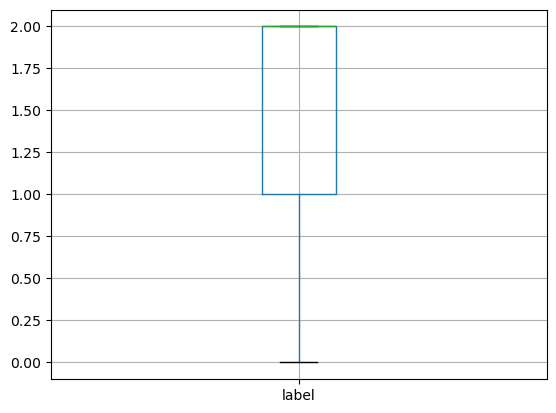

In [8]:
df_train.boxplot(['label'])

To see the words that appear the most in our dataset

In [9]:
all_words = ' '.join(df_train['text']).split()
freq = pd.Series(all_words).value_counts()
freq.sort_values(ascending=False)[0:10]

to     2332
the    1820
of     1464
-      1390
in     1361
on     1136
for    1032
a       970
and     898
The     663
Name: count, dtype: int64

There appears the same word 'the' for example twice because it is in lower and upper case. Therefore we will have to deal with that in the preprocessing steps.

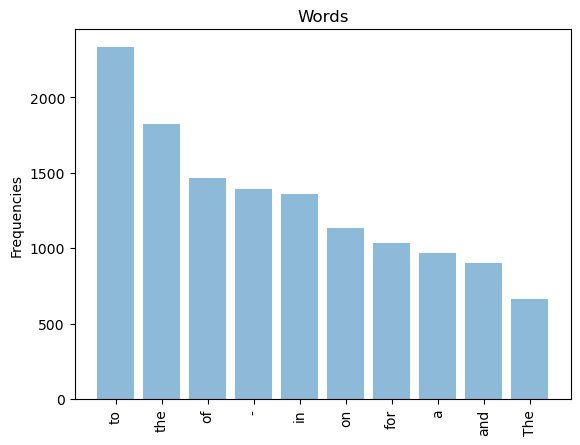

In [10]:
x_labels = freq.index[0:10]
values = freq[:10]
plt.bar(x_labels, values, align='center', alpha=0.5)
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Words')
plt.xticks(rotation=90)
plt.show()

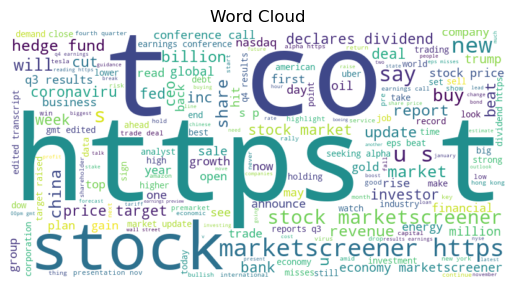

In [11]:
raw_text = ' '.join(df_train['text'].fillna('')).lower()
raw_wc = WordCloud(width=800, height=400, background_color='white').generate(raw_text)
plt.imshow(raw_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

<a class="anchor" id="seven-bullet"> 
<d style="color:white;">

## 1.3. Data Preprocessing
</a> 
</d>   

### 1.3.1. Missing values

In [12]:
if df_train.isnull().sum().sum() > 0:
    print('There are missing values in the dataset')
else: 
    print('There are no missing values in the dataset')  

There are no missing values in the dataset


### 1.3.2. Feature Engineering

To help us visualize the content of our dataset, we will create two new columns: one that counts the total number of characters in each tweet, and another that counts the total number of words.

In [13]:
df_train['text_length'] = df_train['text'].apply(len)
df_train['word_count']  = df_train['text'].apply(lambda x: len(str(x).split(" ")))

In [ ]:
# Count how many tweets have less than 7 characters
num_short_tweets = (df_train['text_length'] < 7).sum()

# Calculate the percentage of tweets with less than 7 characters
percentage_short_tweets = (df_train['text_length'] < 7).mean() * 100

print(f"Number of tweets with less than 7 characters: {num_short_tweets}")
print(f"Percentage: {percentage_short_tweets:.2f}%")

Number of tweets with less than 7 characters: 21
Percentage: 0.22%


Since the percentage of tweets in our dataset with less than 7 characters is very low,  it doesn't even reach 1%, and given that tweets with this length may not be representative or useful for the development of our model, we have decided to remove all entries from the dataset with fewer than 7 characters.

In [16]:
df_train = df_train[df_train['text'].str.len() >= 7]

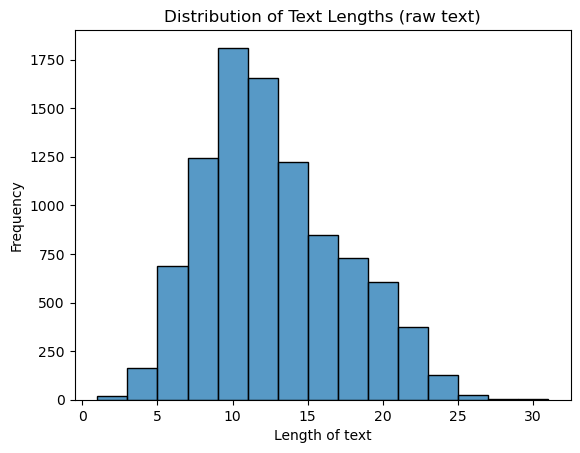

In [17]:
#Plot distribution of text length
sns.histplot(df_train['word_count'], bins=15)
plt.title("Distribution of Text Lengths (raw text)")
plt.xlabel("Length of text")
plt.ylabel("Frequency")
plt.show()

In [18]:
df_train.word_count.describe()

count    9522.000000
mean       12.192712
std         4.626671
min         1.000000
25%         9.000000
50%        11.000000
75%        15.000000
max        31.000000
Name: word_count, dtype: float64

<a class="anchor" id="six-bullet"> 
<d style="color:white;">

### 1.3.3. Outliers
</a> 
</d>   

In [19]:
to_remove = df_train['text_length'].quantile(0.005)

print('We will eliminate the texts with less than', to_remove, 'length')  #0.5 percentile

#to see where the labels of the errors
removed_labels = df_train[df_train['text_length'] < 18]['label'].value_counts()
print(removed_labels)

#to see what is being eliminated:
removed = df_train.loc[df_train['text_length'] < 18, ['text', 'label', 'text_length']]
print(removed)

df_train = df_train[df_train['text_length'] >= 18]
df_train = df_train[df_train['text_length'] >= 18].reset_index(drop=True)

We will eliminate the texts with less than 22.0 length
label
2    21
1     5
Name: count, dtype: int64
                   text  label  text_length
1858   SASA聚酯选用英威达PTA技术      2           16
3090          Brent +4%      1            9
3948            @TicToc      2            7
3980      100% Correct!      2           13
4358  Cya Jason Garrett      2           17
4914         Next week.      2           10
5006      Racing on Ice      2           13
5484    Wholesale Trade      2           15
5512         Woke Sachs      2           10
5654         $penn coin      2           10
6511     Housing Starts      2           14
6849     Nasdaq up 0.2%      1           14
6990  Averages end flat      2           17
7935      $WW heavy....      1           13
8055          Long $WMT      1            9
8153    $APOP on scans.      2           15
8167       $CEI Woke up      2           12
8188     $ETSY 37 to 43      2           14
8235  $NIO on the move.      2           17
8276    $SPY $TNX

### 1.3.4. All text in english

In [23]:
# FOR THIS WE HAVE TO HAVE LOCALLY INSTALLED lid.176.bin

model = fasttext.load_model("lid.176.bin")

def detect_language_fasttext(text):
    try:
        text_cleaned = text.replace('\n', ' ').strip()
        prediction = model.predict(text_cleaned)[0][0]
        return prediction.replace("__label__", "")
    except:
        return "unknown"

df_train['language'] = df_train['text'].apply(detect_language_fasttext)
print(df_train['language'].value_counts())


language
en    9420
de      21
es      14
it      10
fr       8
nl       6
ja       5
pt       3
fi       2
hu       1
vi       1
sv       1
cs       1
zh       1
da       1
is       1
Name: count, dtype: int64


In [25]:
SUPPORTED_LANGS = ['en', 'fr', 'es', 'de', 'it', 'nl', 'ru', 'zh', 'ja', 'ar', 'fi', 'hu', 'vi', 'sv', 'cs', 'da', 'is']
loaded_models = {}

def load_translation_model(src_lang):
    """
    Load and cache a MarianMT translation model for a given source language.

    Parameters:
    src_lang (str): Source language code (e.g., 'fr', 'es', 'de').

    Returns:
    tuple: Tokenizer and model for the given source language.
    """

    model_name = f'Helsinki-NLP/opus-mt-{src_lang}-en'
    if model_name not in loaded_models:
        tokenizer = MarianTokenizer.from_pretrained(model_name)
        model = MarianMTModel.from_pretrained(model_name)
        loaded_models[model_name] = (tokenizer, model)
    return loaded_models[model_name]

def translate_text(text, src_lang):
    """
    Translate a given text to English if it is in a supported non-English language.

    Parameters:
    text (str): Text to be translated.
    src_lang (str): Language code of the text.

    Returns:
    str: Translated text in English or original text if translation is not applicable.
    """
    
    if src_lang == 'en' or src_lang not in SUPPORTED_LANGS:
        return text  
    try:
        tokenizer, model = load_translation_model(src_lang)
        batch = tokenizer([text], return_tensors="pt", padding=True, truncation=True)
        generated = model.generate(**batch)
        translated = tokenizer.decode(generated[0], skip_special_tokens=True)
        return translated
    except Exception as e:
        print(f"Erro ao traduzir ({src_lang}): {e}")
        return text

df_train['translated_text'] = [
    translate_text(text, lang)
    for text, lang in tqdm(zip(df_train['text'], df_train['language']), total=len(df_train))]


# to see it its translating well:
df_train[df_train['language'] == 'fr']

100%|██████████| 9496/9496 [00:00<00:00, 1235585.88it/s]

Erro ao traduzir (es): 
MarianTokenizer requires the SentencePiece library but it was not found in your environment. Checkout the instructions on the
installation page of its repo: https://github.com/google/sentencepiece#installation and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Erro ao traduzir (de): 
MarianTokenizer requires the SentencePiece library but it was not found in your environment. Checkout the instructions on the
installation page of its repo: https://github.com/google/sentencepiece#installation and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Erro ao traduzir (fr): 
MarianTokenizer requires the SentencePiece library but it was not found in your environment. Checkout the instructions on the
installation page of its repo: https://github.com/google/sentencepiece#installation and follow the ones
that match your environment. P

,text,label,text_length,word_count,language,translated_text
1449,Eudonet annonce un chiffre d’affaires récurren...,2,82,13,fr,Eudonet annonce un chiffre d’affaires récurren...
1837,Rio Tinto’s Giant Mongolia Project Dealt Anoth...,2,53,6,fr,Rio Tinto’s Giant Mongolia Project Dealt Anoth...
1961,Tinyclues accélère sa croissance en 2019,2,40,6,fr,Tinyclues accélère sa croissance en 2019
4313,Cloudia lance la dernière génération de soluti...,2,93,13,fr,Cloudia lance la dernière génération de soluti...
4777,Korian s’associe à Omedys pour développer le p...,2,114,16,fr,Korian s’associe à Omedys pour développer le p...
5342,Total : Résultats du quatrième trimestre et de...,2,59,10,fr,Total : Résultats du quatrième trimestre et de...
5488,Will China Declare Force Majeure If Virus Situ...,2,60,9,fr,Will China Declare Force Majeure If Virus Situ...
8672,Is Les Hôtels de Paris (EPA:HDP) Using Too Muc...,2,53,10,fr,Is Les Hôtels de Paris (EPA:HDP) Using Too Muc...


### 1.3.5. Text cleaning

Application of a formula that will:
1. Remove the stopwords
2. Stemeatize & Lematize
3. Put everything in lowercase
3. Remove weird characters

In [30]:
# Set of English stopwords to filter out common, uninformative words
stop = set(stopwords.words('english'))
print(stop)

# Snowball stemmer to reduce words to their root form
stemmer = SnowballStemmer('english')

# WordNet lemmatizer to convert words to their base or dictionary form
lemma = WordNetLemmatizer()


# Cleaning Function
def clean(text_list, stopwords=True, lemmatize=True, stem=False, correct_spelling=False):
    """
    Clean a list of text strings by applying lowercasing, regex filters, and optional NLP steps.

    Parameters:
    text_list (list): List of text entries (strings) to clean.
    stopwords (bool): If True, removes English stopwords.
    lemmatize (bool): If True, applies lemmatization to each word.
    stem (bool): If True, applies stemming to each word (not recommended with lemmatization).
    correct_spelling (bool): If True, applies spelling correction (slow process).

    Returns:
    list: List of cleaned text strings.
    """

    cleaned = []
    for text in tqdm(text_list):
        text = text.lower()                                            # convert text to lowercase
        text = re.sub(r"http\S+", "", text)                            # remove links
        text = re.sub("[^a-zA-Z]", " ", text)                          # remove numbers and non-alphabetic characters
        text = re.sub("br", "", text)                                  # remove occurrences of "br" (often from HTML tags)
        text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)  # remove extra punctuation
        

        if stopwords:
            text = " ".join([word for word in text.split() if word not in stop])

        if correct_spelling:
            text = str(TextBlob(text).correct())

        if lemmatize:
            text = " ".join(lemma.lemmatize(word) for word in text.split())

        if stem:
            text = " ".join(stemmer.stem(word) for word in text.split())

        cleaned.append(text)

    return cleaned

# Initial cleaning: remove empty or None entries
df_train = df_train[df_train['translated_text'].notnull()]
df_train = df_train[df_train['translated_text'].str.strip() != ""]

df_test = df_test[df_test['text'].notnull()]
df_test = df_test[df_test['text'].str.strip() != ""]

# Apply cleaning function
df_train['clean_text'] = clean(df_train['translated_text'], stopwords=True, lemmatize=True, stem=False, correct_spelling=False)
df_test['clean_text'] = clean(df_test['text'], stopwords=True, lemmatize=True, stem=False, correct_spelling=False)

# View original and cleaned texts
df_train[['text', 'clean_text']].head()

{'hasn', 'does', 'hers', "i'll", 'myself', 'weren', 'she', 'be', 'which', 'down', 'were', 'his', "isn't", 'had', "she'll", "they'll", 'himself', "she'd", 'very', "needn't", "we're", 're', 'their', 'few', 'ma', 'against', 'not', 'we', "weren't", 'how', 'do', 'hadn', 'an', 'nor', 'through', 'your', 'won', 'was', 'll', 'any', 'if', 'did', "aren't", 'don', 's', 'a', 'during', 'own', 'each', "won't", 'are', 'it', 'can', 'some', 'before', 'you', 'ourselves', 'by', "he'll", 'ain', "mustn't", 'after', 'over', "he's", 'those', "you're", 'wouldn', 'her', "it's", "she's", 'him', 'there', "we've", "wouldn't", "couldn't", 'its', 'off', 'again', 'with', 'both', 'theirs', "don't", 'out', 'doesn', "we'd", 'but', 'from', 'will', 'have', "they're", "it'll", "it'd", 'me', 'just', 'my', 'being', 'above', 'isn', 'here', 'then', 'am', 'haven', 'them', 'below', 'for', "that'll", "i'm", 'mustn', 'shan', 'm', 'on', 'when', 'itself', 'up', 'been', 'wasn', 'o', 'i', 'aren', 'now', "they'd", 've', 'what', "haven'

  0%|          | 0/9496 [00:00<?, ?it/s]

100%|██████████| 2388/2388 [00:00<00:00, 15382.67it/s]


,text,clean_text
0,$BYND - JPMorgan reels in expectations on Beyo...,bynd jpmorgan reel expectation beyond meat
1,$CCL $RCL - Nomura points to bookings weakness...,ccl rcl nomura point booking weakness carnival...
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",cx cemex cut credit suisse j p morgan weak bui...
3,$ESS: BTIG Research cuts to Neutral https://t....,es btig research cut neutral
4,$FNKO - Funko slides after Piper Jaffray PT cu...,fnko funko slide piper jaffray pt cut


### 1.3.6. Removing unsual words

To further reduce noise in our dataset and improve the potential performance of our models, we will remove all words that appear only once in the dataset, as these are extremely rare and likely insignificant for our problem.

In [31]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_train['clean_text'])
words = vectorizer.get_feature_names_out()
word_counts = X.toarray().sum(axis=0)
words_once = [word for word, count in zip(words, word_counts) if count == 1]

print("Words that appear only once:", words_once)

Words that appear only once: ['aaa', 'aaham', 'aams', 'aaon', 'aav', 'aaww', 'aaza', 'abalone', 'abandoned', 'abandoning', 'abbott', 'abe', 'abebe', 'aben', 'abeo', 'aberdeen', 'abeviated', 'abiy', 'abn', 'abo', 'abolish', 'aborted', 'absol', 'absorb', 'absurdity', 'abu', 'abukarsh', 'abusing', 'abv', 'academic', 'acceleron', 'acceleronpharma', 'accendowave', 'acceptance', 'accessing', 'accesswi', 'acciones', 'accommodate', 'accomplish', 'accomplished', 'accor', 'accordi', 'accordingly', 'accretive', 'accumulated', 'accumulating', 'accuracy', 'accurately', 'accusation', 'accuses', 'acea', 'acelerada', 'acelrx', 'ach', 'achieved', 'achieving', 'acknowledged', 'acknowledging', 'acme', 'acmr', 'acorncapitalinvestmentfund', 'acqu', 'acquisizioni', 'acquittal', 'acrx', 'actinogen', 'actinogenmedical', 'activated', 'activates', 'actividades', 'activism', 'actuall', 'actuarial', 'acu', 'acui', 'acw', 'adam', 'adani', 'adapt', 'addict', 'addicted', 'adecco', 'adenatfriedman', 'adesco', 'adesto

In [32]:
words_once_set = set(words_once)

def remove_rare_words(text):
    """
    Remove words from a text string that appear only once in the training corpus.

    Parameters:
    text (str): The input text to clean.

    Returns:
    str: The text with rare words removed (i.e., words that appear only once in the corpus).
    """
    
    return ' '.join([word for word in text.split() if word not in words_once_set])

df_train['clean_text'] = df_train['clean_text'].apply(remove_rare_words)

<a class="anchor" id="four-bullet"> 
<d style="color:white;">

## 1.4. Corpus Splitting
</a> 
</d>   

Since we initially preserved the original content of our dataset, we will use it to test two different modeling approaches. The first uses the cleaned version of our dataset, with all the preprocessing steps applied throughout this notebook, which will be used for more traditional models (e.g. Logistic Regression and KNN). The second approach uses the untouched, original version of the dataset, which will be used with pre-trained models such as BERT and RoBERTa. To proceed, we begin by splitting each version of the dataset into training and validation sets.

In [33]:
# SPLIT FOR MODELS WITH CLEANED TEXT
X_train = df_train['clean_text']
y_train = df_train['label'] 

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=df_train['label'], random_state=42)

In [34]:
# 2. SPLIT FOR MODELS WITH RAW TEXT (FOR PRE-TRAINED MODELS)
X_raw = df_train_raw['text']
y_raw = df_train_raw['label']

X_train_raw, X_val_raw, y_train_raw, y_val_raw = train_test_split(X_raw, y_raw, test_size=0.2, stratify=y_raw, random_state=42)

<a class="anchor" id="five-bullet"> 
<d style="color:white;">

## 1.5. Embeddings
</a> 
</d>   

In [ ]:
def bow_or_tfidf(texts = df_train['clean_text'], method='bow'):
    """
    Convert a list of text documents into a numerical feature matrix using either
    Bag of Words (BoW) or TF-IDF vectorization.

    Parameters:
    texts (list or pandas Series): Collection of text documents to vectorize.
    method (str): Vectorization method to use. Must be either 'bow' or 'tfidf'.

    Returns:
    tuple: A tuple containing:
        - X (scipy sparse matrix): The document-term matrix.
        - vectorizer (CountVectorizer or TfidfVectorizer): The fitted vectorizer instance.

    Raises:
    ValueError: If the provided method is not 'bow' or 'tfidf'.
    """
    
    if method == 'bow':
        vectorizer = CountVectorizer()
        X = vectorizer.fit_transform(texts)
        return X, vectorizer

    elif method == 'tfidf':
        vectorizer = TfidfVectorizer()
        X = vectorizer.fit_transform(texts)
        return X, vectorizer

    else:
        raise ValueError("Choose a valid method: 'bow', 'tfidf'.")

# X_train, vectorizer = bow_or_tfidf(df_train['clean_text'], method='bow')
# X_train, vectorizer = bow_or_tfidf(df_train['clean_text'], method='tfidf')

### 1.5.1. Bag of Words (BoW)

In [78]:
X_train_bow, vectorizer = bow_or_tfidf(X_train, method='bow')
X_val_bow = vectorizer.transform(X_val)
#X_test_bow = vectorizer.transform(df_test['clean_text']) 

### 1.5.2. TF-IDF

In [79]:
X_train_tfidf, vectorizer = bow_or_tfidf(X_train, method='tfidf')
X_val_tfidf = vectorizer.transform(X_val)
#X_test_tfidf = vectorizer.transform(df_test['clean_text']) 

### 1.5.3 Word2Vec

In [80]:
# Train the Word2Vec model only once
tokenized_train = [text.split() for text in X_train]
model = Word2Vec(sentences=tokenized_train, vector_size=100, window=2, min_count=1, sg=1)
word_vectors = model.wv

# Function only to generate the document embedding
def get_doc_embedding(doc, word_vectors, dim=100):
    tokens = doc.split()
    vectors = [word_vectors[word] for word in tokens if word in word_vectors.index_to_key]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(dim)

# Create the embeddings efficiently
X_train_emb = np.vstack([get_doc_embedding(doc, word_vectors) for doc in X_train])
X_val_emb = np.vstack([get_doc_embedding(doc, word_vectors) for doc in X_val])

### 1.5.4 GloVe

In [81]:
# Escolher o modelo GloVe pré-treinado
model_name = 'glove-twitter'
emb_size = 100  # Podes usar 25, 50, 100 ou 200 dependendo da capacidade desejada

# Carregar o modelo GloVe
w2v = gensim.downloader.load(f'{model_name}-{emb_size}')

# Função para converter cada documento num conjunto de vetores de palavras
def corpus2vec(corpus, w2v):
    index_set = set(w2v.index_to_key)  # Para lookup rápido
    word_vec = w2v.get_vector           # Atalho para mais rápido
    return [
        [word_vec(word) for word in doc.split() if word in index_set]
        for doc in tqdm(corpus)
    ]

# Aplicar aos teus dados de treino e validação
x_train_vec = corpus2vec(X_train, w2v)
x_val_vec = corpus2vec(X_val, w2v)

# Agora converter cada tweet num único vetor (média dos vetores das palavras)
def average_vectors(vector_list, dim):
    return np.mean(vector_list, axis=0) if vector_list else np.zeros(dim)

X_train_glove_avg = np.vstack([average_vectors(vecs, emb_size) for vecs in x_train_vec])
X_val_glove_avg = np.vstack([average_vectors(vecs, emb_size) for vecs in x_val_vec])

[==================================================] 100.0% 387.1/387.1MB downloaded


100%|██████████| 1900/1900 [00:00<00:00, 13378.47it/s]


In [82]:
w2v.most_similar('happy', topn=10)

[('birthday', 0.9259342551231384),
 ('day', 0.8549739718437195),
 ('bday', 0.814542829990387),
 ('merry', 0.7886534929275513),
 ('love', 0.785590648651123),
 ('wish', 0.7771797776222229),
 ('hope', 0.7660955190658569),
 ('thank', 0.7639737725257874),
 ('year', 0.750583291053772),
 ('thanks', 0.7475084066390991)]

### 1.5.5 RoBERTa

In [83]:
# CORRER ROBERTA SEM DATA CLEANING

In [84]:
# Load pretrained RoBERTa model and tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')
model.eval()  # Set to eval mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Function to convert corpus to embeddings (Corpus2Vec using [CLS] token)
def roberta_corpus2vec(corpus, tokenizer, model, max_length=128):
    embeddings = []
    with torch.no_grad():
        for doc in tqdm(corpus):
            inputs = tokenizer(doc, return_tensors='pt', padding='max_length',
                               truncation=True, max_length=max_length)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze(0)  # CLS token
            embeddings.append(cls_embedding.cpu().numpy())
    return np.vstack(embeddings)

# Encode train and validation sets with original (raw) text
X_train_roberta = roberta_corpus2vec(X_train_raw, tokenizer, model)
X_val_roberta = roberta_corpus2vec(X_val_raw, tokenizer, model)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

c:\Users\Rafael\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Rafael\.cache\huggingface\hub\models--roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 1909/1909 [04:48<00:00,  6.61it/s]


<a class="anchor" id="five-bullet"> 
<d style="color:white;">

## 1.8. SMOTE
</a> 
</d>   

We are going to use SMOTE to handle data imbalance in some models where is not possible to apply class weights.

In [85]:
smote = SMOTE(random_state=13)

X_train_roberta_resampled, y_train_resampled = smote.fit_resample(X_train_roberta, y_train)

# X_train_glove_avg_resampled, y_train_resampled = smote.fit_resample(X_train_glove_avg, y_train)
# X_train_emb_resampled, y_train_resampled = smote.fit_resample(X_train_emb, y_train)
# X_train_bow_resampled, y_train_resampled = smote.fit_resample(X_train_bow, y_train)
# X_train_tfidf_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [7634, 7596]

<hr>
<a class="anchor" id="eight-bullet"> 
<d style="color:white;">

# 2. Models
</a> 
</d>   

<a class="anchor" id="nine-bullet"> 
<d style="color:white;">

## 2.1. Functions
</a> 
</d>   

### 2.1.1. Function for evaluation of the model

In [ ]:
def evaluate_model_predictions(y_pred_train, y_pred_val, y_train = y_train, y_val = y_val, show_confusion_matrix = True, show_classification_report = True):
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train, average='macro')
    
    val_accuracy = accuracy_score(y_val, y_pred_val)
    val_f1 = f1_score(y_val, y_pred_val, average='macro')

    val_precision = precision_score(y_val, y_pred_val, average='macro')
    val_recall = recall_score(y_val, y_pred_val, average='macro')

    print(f"Accuracy of train: {train_accuracy:.4f}")
    print(f"F1 Macro (Train): {train_f1:.4f}")
    print(f"Accuracy of val: {val_accuracy:.4f}")
    print(f"\033[1mF1 Macro (Val)\033[0m: {val_f1:.4f}")
    print(f"Precision (Val): {val_precision:.4f}")
    print(f"Recall (Val): {val_recall:.4f}")
    
    if show_confusion_matrix==True:
        print('\nConfusion Matrix for Validation Data:')    
        print(confusion_matrix(y_val, y_pred_val))

    if show_classification_report==True:
        print('\nClassification Report for Validation Data:')
        print(classification_report(y_val, y_pred_val))

    return train_accuracy, train_f1, val_accuracy, val_f1

<a class="anchor" id="ten-bullet"> 
<d style="color:white;">

## 2.2. Classification Models
</a> 
</d> 

### 2.2.1. Naive Bayes

#### With BOW

In [ ]:
nb = MultinomialNB()
nb.fit(X_train_bow, y_train)
y_pred_train = nb.predict(X_train_bow)
y_pred_val = nb.predict(X_val_bow)

nb_bow_train_accuracy, nb_bow_train_f1_macro, nb_bow_val_accuracy, nb_bow_val_f1_macro = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val=y_pred_val)

Accuracy of train: 0.8838
F1 Macro (Train): 0.8475
Accuracy of val: 0.7716
F1 Macro (Val): 0.6794
Precision (Val): 0.6991
Recall (Val): 0.6651

Confusion Matrix for Validation Data:
[[ 142   52   94]
 [  26  237  121]
 [  61   80 1087]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.62      0.49      0.55       288
           1       0.64      0.62      0.63       384
           2       0.83      0.89      0.86      1228

    accuracy                           0.77      1900
   macro avg       0.70      0.67      0.68      1900
weighted avg       0.76      0.77      0.77      1900



#### With TF-IDF

In [ ]:
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred_train = nb.predict(X_train_tfidf)
y_pred_val = nb.predict(X_val_tfidf)

# Results
nb_idf_train_accuracy, nb_idf_train_f1_macro, nb_idf_val_accuracy, nb_idf_val_f1_macro = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val=y_pred_val)

Accuracy of train: 0.7838
F1 Macro (Train): 0.6419
Accuracy of val: 0.7353
F1 Macro (Val): 0.5351
Precision (Val): 0.8240
Recall (Val): 0.5023

Confusion Matrix for Validation Data:
[[  46   17  225]
 [   3  138  243]
 [   0   15 1213]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.94      0.16      0.27       288
           1       0.81      0.36      0.50       384
           2       0.72      0.99      0.83      1228

    accuracy                           0.74      1900
   macro avg       0.82      0.50      0.54      1900
weighted avg       0.77      0.74      0.68      1900



### 2.2.2. Logistic Regression 

#### With BOW

In [ ]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train_bow, y_train)
y_pred_train = lr.predict(X_train_bow)
y_pred_val = lr.predict(X_val_bow)

# Results:
lr_bow_train_accuracy, lr_bow_train_f1_macro, lr_bow_val_accuracy, lr_bow_val_f1_macro = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val =y_pred_val)

Accuracy of train: 0.9508
F1 Macro (Train): 0.9397
Accuracy of val: 0.7758
F1 Macro (Val): 0.6990
Precision (Val): 0.6962
Recall (Val): 0.7028

Confusion Matrix for Validation Data:
[[ 178   42   68]
 [  47  243   94]
 [  90   85 1053]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.57      0.62      0.59       288
           1       0.66      0.63      0.64       384
           2       0.87      0.86      0.86      1228

    accuracy                           0.78      1900
   macro avg       0.70      0.70      0.70      1900
weighted avg       0.78      0.78      0.78      1900



#### With TF-IDF

In [ ]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced') 
lr.fit(X_train_tfidf, y_train)
y_pred_train = lr.predict(X_train_tfidf)
y_pred_val = lr.predict(X_val_tfidf)

# Results:
lr_idf_train_accuracy, lr_idf_train_f1_macro, lr_idf_val_accuracy, lr_idf_val_f1_macro = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val =y_pred_val)

Accuracy of train: 0.9057
F1 Macro (Train): 0.8843
Accuracy of val: 0.7784
F1 Macro (Val): 0.7028
Precision (Val): 0.6994
Recall (Val): 0.7074

Confusion Matrix for Validation Data:
[[ 181   41   66]
 [  48  244   92]
 [  89   85 1054]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.57      0.63      0.60       288
           1       0.66      0.64      0.65       384
           2       0.87      0.86      0.86      1228

    accuracy                           0.78      1900
   macro avg       0.70      0.71      0.70      1900
weighted avg       0.78      0.78      0.78      1900



#### With Word2Vec

In [ ]:
clf = LogisticRegression(max_iter=1000, class_weight='balanced') # Use class_weight='balanced' to handle class imbalance
clf.fit(X_train_emb, y_train)

y_pred_train = clf.predict(X_train_emb)
y_pred_val = clf.predict(X_val_emb)

lr_emb_train_accuracy, lr_emb_train_f1_macro, lr_emb_val_accuracy, lr_idf_val_f1_macro = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val =y_pred_val)

NameError: name 'X_train_emb' is not defined

#### With Roberta

In [ ]:
# Train classifier with balanced class weights
clf = LogisticRegression(max_iter=1000, class_weight='balanced')
clf.fit(X_train_roberta, y_train)

# Predict and evaluate
y_pred_train = clf.predict(X_train_roberta)
y_pred_val = clf.predict(X_val_roberta)

train_acc, train_f1, val_acc, val_f1 = evaluate_model_predictions(
    y_pred_train, y_pred_val, y_train=y_train, y_val=y_val, 
    show_confusion_matrix=True, show_classification_report=True)

Accuracy of train: 0.8047
F1 Macro (Train): 0.7629
Accuracy of val: 0.7999
F1 Macro (Val): 0.7453
Precision (Val): 0.7285
Recall (Val): 0.7729

Confusion Matrix for Validation Data:
[[ 216   32   40]
 [  44  284   57]
 [ 127   82 1027]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.56      0.75      0.64       288
           1       0.71      0.74      0.73       385
           2       0.91      0.83      0.87      1236

    accuracy                           0.80      1909
   macro avg       0.73      0.77      0.75      1909
weighted avg       0.82      0.80      0.81      1909



### 2.2.3. KNN

#### With BOW

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5) 
knn.fit(X_train_bow, y_train)

y_pred_train = knn.predict(X_train_bow)
y_pred_val = knn.predict(X_val_bow)

knn_bow_train_accuracy, knn_bow_train_f1_macro, knn_bow_val_accuracy, knn_bow_val_f1_macro = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val=y_pred_val)

Accuracy of train: 0.7630
F1 Macro (Train): 0.6066
Accuracy of val: 0.6983
F1 Macro (Val): 0.4660
Precision (Val): 0.6784
Recall (Val): 0.4502

Confusion Matrix for Validation Data:
[[  37   14  237]
 [  11   97  277]
 [  11   26 1199]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.63      0.13      0.21       288
           1       0.71      0.25      0.37       385
           2       0.70      0.97      0.81      1236

    accuracy                           0.70      1909
   macro avg       0.68      0.45      0.47      1909
weighted avg       0.69      0.70      0.63      1909



#### With Roberta

In [ ]:
clf_knn = KNeighborsClassifier(n_neighbors=5)
clf_knn.fit(X_train_roberta, y_train)

y_pred_train_knn = clf_knn.predict(X_train_roberta)
y_pred_val_knn = clf_knn.predict(X_val_roberta)

evaluate_model_predictions(y_pred_train_knn, y_pred_val_knn)

Accuracy of train: 0.8495
F1 Macro (Train): 0.7811
Accuracy of val: 0.7774
F1 Macro (Val): 0.6686
Precision (Val): 0.6787
Recall (Val): 0.6605

Confusion Matrix for Validation Data:
[[ 130   67   91]
 [  57  243   85]
 [  64   61 1111]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.52      0.45      0.48       288
           1       0.65      0.63      0.64       385
           2       0.86      0.90      0.88      1236

    accuracy                           0.78      1909
   macro avg       0.68      0.66      0.67      1909
weighted avg       0.77      0.78      0.77      1909



(0.8494891275871103,
 0.7811450690204408,
 0.7773703509690938,
 0.6686431643965193)

### 2.2.4. MLP

#### With BOW

In [ ]:
mlp = MLPClassifier(solver='adam', hidden_layer_sizes=(2,2), activation='logistic', random_state=1)
mlp.fit(X_train_bow, y_train)

y_pred_train = mlp.predict(X_train_bow)
y_pred_val = mlp.predict(X_val_bow)

mlp_bow_train_accuracy, mlp_bow_train_f1_macro, mlp_bow_val_accuracy, mlp_bow_val_f1_macro = evaluate_model_predictions(y_pred_train=y_pred_train, y_pred_val=y_pred_val)

Accuracy of train: 0.9928
F1 Macro (Train): 0.9903
Accuracy of val: 0.7653
F1 Macro (Val): 0.6774
Precision (Val): 0.6923
Recall (Val): 0.6652

Confusion Matrix for Validation Data:
[[ 149   40   99]
 [  25  233  127]
 [  87   70 1079]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.57      0.52      0.54       288
           1       0.68      0.61      0.64       385
           2       0.83      0.87      0.85      1236

    accuracy                           0.77      1909
   macro avg       0.69      0.67      0.68      1909
weighted avg       0.76      0.77      0.76      1909



c:\Users\marsi\anaconda3\envs\DM2425\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


#### With Roberta

In [ ]:
clf_mlp = MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=300, random_state=42)
clf_mlp.fit(X_train_roberta, y_train)

y_pred_train_mlp = clf_mlp.predict(X_train_roberta)
y_pred_val_mlp = clf_mlp.predict(X_val_roberta)

evaluate_model_predictions(y_pred_train_mlp, y_pred_val_mlp)

Accuracy of train: 0.9878
F1 Macro (Train): 0.9826
Accuracy of val: 0.8402
F1 Macro (Val): 0.7727
Precision (Val): 0.7938
Recall (Val): 0.7589

Confusion Matrix for Validation Data:
[[ 197   21   70]
 [  45  254   86]
 [  53   30 1153]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.67      0.68      0.68       288
           1       0.83      0.66      0.74       385
           2       0.88      0.93      0.91      1236

    accuracy                           0.84      1909
   macro avg       0.79      0.76      0.77      1909
weighted avg       0.84      0.84      0.84      1909



(0.9878176578464762,
 0.9825741847178704,
 0.8402304871660555,
 0.7727123362084544)

### 2.2.5. LSTM

#### 2.2.5.1. LSTM with randomly initialized trainable embeddings

In [ ]:
# Tokenize text
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=100, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=100, padding='post', truncating='post')

# Convert labels to one-hot
y_train_cat = to_categorical(y_train, num_classes=3)
y_val_cat = to_categorical(y_val, num_classes=3)

# Ensure dtype is correct to avoid "Invalid dtype: object"
X_train_pad = np.array(X_train_pad, dtype='int32')
X_val_pad = np.array(X_val_pad, dtype='int32')
y_train_cat = np.array(y_train_cat, dtype='float32')
y_val_cat = np.array(y_val_cat, dtype='float32')

# Build LSTM model
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=64, input_length=100))
model.add(LSTM(64))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_pad, y_train_cat, epochs=5, batch_size=32, validation_data=(X_val_pad, y_val_cat))

# Predict 
y_pred_train = model.predict(X_train_pad)
y_pred_val = model.predict(X_val_pad)

# Convert predictions to class labels
y_pred_train_labels = np.argmax(y_pred_train, axis=1)
y_pred_val_labels = np.argmax(y_pred_val, axis=1)

# Also convert true labels to integers
y_train_labels = np.argmax(y_train_cat, axis=1)
y_val_labels = np.argmax(y_val_cat, axis=1)

# Evaluate 
lstm_train_acc, lstm_train_f1, lstm_val_acc, lstm_val_f1 = evaluate_model_predictions(
    y_pred_train_labels, y_pred_val_labels,
    y_train=y_train_labels, y_val=y_val_labels
)

c:\Users\marsi\anaconda3\envs\DM2425\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
239/239 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - accuracy: 0.6281 - loss: 0.9190 - val_accuracy: 0.6475 - val_loss: 0.8910
Epoch 2/5
239/239 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.6527 - loss: 0.8855 - val_accuracy: 0.6475 - val_loss: 0.8900
Epoch 3/5
239/239 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - accuracy: 0.6402 - loss: 0.9001 - val_accuracy: 0.6475 - val_loss: 0.8974
Epoch 4/5
239/239 ━━━━━━━━━━━━━━━━━━━━ 28s 116ms/step - accuracy: 0.6507 - loss: 0.8859 - val_accuracy: 0.6475 - val_loss: 0.8906
Epoch 5/5
239/239 ━━━━━━━━━━━━━━━━━━━━ 26s 108ms/step - accuracy: 0.6539 - loss: 0.8827 - val_accuracy: 0.6475 - val_loss: 0.8905
239/239 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Accuracy of train: 0.6474
F1 Macro (Train): 0.2620
Accuracy of val: 0.6475
F1 Macro (Val): 0.2620
Precision (Val): 0.2158
Recall (Val): 0.3333

Confusion Matrix for Validation Data:
[[   0    0  288]
 [   0    0  385]
 [   0    0 1236]]

Classification Report for Validat

c:\Users\marsi\anaconda3\envs\DM2425\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\marsi\anaconda3\envs\DM2425\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\marsi\anaconda3\envs\DM2425\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\U

#### 2.2.5.2. LSTM model using GloVe embeddings

In [ ]:
# Determinar o comprimento máximo das sequências no treino
max_len = max(len(seq) for seq in x_train_vec)

# Aplicar padding (com zeros ao final)
X_train_glove_pad = pad_sequences(x_train_vec, maxlen=max_len, padding='post', dtype='float64')
X_val_glove_pad = pad_sequences(x_val_vec, maxlen=max_len, padding='post', dtype='float64')

# Converter os labels para one-hot encoding
y_train_lstm = to_categorical(y_train, num_classes=3)
y_val_lstm = to_categorical(y_val, num_classes=3)

model = Sequential()
model.add(Masking(mask_value=0., input_shape=(max_len, emb_size)))  # Ignorar vetores de padding
model.add(LSTM(128, return_sequences=False))  # LSTM com 128 unidades
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # 3 classes: positivo, negativo, neutro

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(
    X_train_glove_pad, y_train_lstm,
    validation_data=(X_val_glove_pad, y_val_lstm),
    epochs=10,
    batch_size=32,
    verbose=1)

c:\Users\marsi\anaconda3\envs\DM2425\Lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 22, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,635 (459.51 KB)

 Trainable params: 117,635 (459.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.6539 - loss: 0.8422 - val_accuracy: 0.7203 - val_loss: 0.6825
Epoch 2/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7287 - loss: 0.6753 - val_accuracy: 0.7365 - val_loss: 0.6602
Epoch 3/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.7475 - loss: 0.6249 - val_accuracy: 0.7287 - val_loss: 0.6594
Epoch 4/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7738 - loss: 0.5708 - val_accuracy: 0.7543 - val_loss: 0.6179
Epoch 5/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8031 - loss: 0.5156 - val_accuracy: 0.7627 - val_loss: 0.6258
Epoch 6/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.8137 - loss: 0.4683 - val_accuracy: 0.7643 - val_loss: 0.6025
Epoch 7/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.8459 - loss: 0.4077 - val_accuracy: 0.7658 - val_loss: 0.6376
Epoch 8/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.8609 - loss: 0.3654 - val_a

In [ ]:
# Converter previsões one-hot (ou probabilidades softmax) em rótulos (argmax)
y_pred_train_labels = np.argmax(model.predict(X_train_glove_pad), axis=1)
y_pred_val_labels = np.argmax(model.predict(X_val_glove_pad), axis=1)

# Agora sim, podes avaliar corretamente:
lstm_train_acc, lstm_train_f1, lstm_val_acc, lstm_val_f1 = evaluate_model_predictions(
    y_pred_train=y_pred_train_labels, 
    y_pred_val=y_pred_val_labels,
    y_train=y_train, 
    y_val=y_val)

239/239 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Accuracy of train: 0.9295
F1 Macro (Train): 0.9011
Accuracy of val: 0.7611
F1 Macro (Val): 0.6568
Precision (Val): 0.7111
Recall (Val): 0.6292

Confusion Matrix for Validation Data:
[[ 119   38  131]
 [  15  221  149]
 [  38   85 1113]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.69      0.41      0.52       288
           1       0.64      0.57      0.61       385
           2       0.80      0.90      0.85      1236

    accuracy                           0.76      1909
   macro avg       0.71      0.63      0.66      1909
weighted avg       0.75      0.76      0.75      1909



### 2.2.6. XGBOOST

#### 2.2.6.1. With Roberta

In [ ]:
# WITH SMOTE

clf_xgb = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=13)

clf_xgb.fit(X_train_roberta_resampled, y_train_resampled)

y_pred_train_xgb = clf_xgb.predict(X_train_roberta)
y_pred_val_xgb = clf_xgb.predict(X_val_roberta)

evaluate_model_predictions(
    y_pred_train=y_pred_train_xgb,
    y_pred_val=y_pred_val_xgb)

c:\Users\marsi\anaconda3\envs\DM2425\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:48:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy of train: 0.9159
F1 Macro (Train): 0.8947
Accuracy of val: 0.7999
F1 Macro (Val): 0.7235
Precision (Val): 0.7220
Recall (Val): 0.7251

Confusion Matrix for Validation Data:
[[ 177   46   65]
 [  47  262   76]
 [  70   78 1088]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.60      0.61      0.61       288
           1       0.68      0.68      0.68       385
           2       0.89      0.88      0.88      1236

    accuracy                           0.80      1909
   macro avg       0.72      0.73      0.72      1909
weighted avg       0.80      0.80      0.80      1909



(0.9159025412627718,
 0.8947059644480464,
 0.7998952331063384,
 0.7235476262163086)

### 2.2.7. Ensemble Model with Voting Classifier Combining Logistic Regression, MLP, and XGBoost

In [ ]:
clf1 = LogisticRegression(class_weight='balanced', max_iter=1000)
clf2 = MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=300)
clf3 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

ensemble = VotingClassifier(estimators=[
    ('lr', clf1), ('mlp', clf2), ('xgb', clf3)
], voting='hard')

ensemble.fit(X_train_roberta, y_train)
y_pred_val = ensemble.predict(X_val_roberta)

y_pred_train = ensemble.predict(X_train_roberta)
evaluate_model_predictions(y_pred_train, y_pred_val)

Accuracy of train: 0.9988
F1 Macro (Train): 0.9985
Accuracy of val: 0.8392
F1 Macro (Val): 0.7780
Precision (Val): 0.7875
Recall (Val): 0.7720

Confusion Matrix for Validation Data:
[[ 203   22   63]
 [  39  268   78]
 [  65   40 1131]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.66      0.70      0.68       288
           1       0.81      0.70      0.75       385
           2       0.89      0.92      0.90      1236

    accuracy                           0.84      1909
   macro avg       0.79      0.77      0.78      1909
weighted avg       0.84      0.84      0.84      1909



(0.9988210636625622,
 0.9984699913930409,
 0.8391828182294395,
 0.7779723888083021)

It is possible to see that the ensemble model is overfitting the training data, as it achieves significantly better performance on the training set compared to the validation set. To address this overfitting issue, we applied SMOTE to balance the training data and improve generalization, as shown in the following code.

In [ ]:
# Logistic Regression com regularização mais forte
clf1 = LogisticRegression(class_weight='balanced', max_iter=1000, C=0.5)  # menor C = mais regularização

# MLP com regularização L2 e early stopping (usa validação interna)
clf2 = MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=300, alpha=0.001, early_stopping=True, validation_fraction=0.1, n_iter_no_change=10, random_state=42)

# XGBoost com early stopping e regularização
clf3 = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_estimators=100,  # menos árvores para reduzir overfitting
    learning_rate=0.1,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=13)

ensemble = VotingClassifier(
    estimators=[('lr', clf1), ('mlp', clf2), ('xgb', clf3)],
    voting='soft')

ensemble.fit(X_train_roberta, y_train)

y_pred_train = ensemble.predict(X_train_roberta)
y_pred_val = ensemble.predict(X_val_roberta)

evaluate_model_predictions(y_pred_train, y_pred_val)

c:\Users\marsi\anaconda3\envs\DM2425\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:08:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy of train: 0.9318
F1 Macro (Train): 0.9112
Accuracy of val: 0.8277
F1 Macro (Val): 0.7490
Precision (Val): 0.7911
Recall (Val): 0.7201

Confusion Matrix for Validation Data:
[[ 160   30   98]
 [  25  255  105]
 [  35   36 1165]]

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.73      0.56      0.63       288
           1       0.79      0.66      0.72       385
           2       0.85      0.94      0.89      1236

    accuracy                           0.83      1909
   macro avg       0.79      0.72      0.75      1909
weighted avg       0.82      0.83      0.82      1909



(0.9317526853549908,
 0.9111516185938814,
 0.8276584599266632,
 0.7490260429956536)

### 2.2.8. RoBERTa (Hugging Face Pipeline)

In [ ]:
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"

# Load Hugging Face pipeline
hf_classifier = pipeline(
    "text-classification",
    model=MODEL,
    tokenizer=MODEL,
    device=0 if torch.cuda.is_available() else -1,
    truncation=True
)

# Make predictions
preds = hf_classifier(list(X_val_raw))

# Map model's labels to integers
label_to_int = {"LABEL_0": 0, "LABEL_1": 1, "LABEL_2": 2}
y_pred_val = [label_to_int[pred['label']] for pred in preds]

# Evaluation
def evaluate_model_predictions1(y_pred_val, y_val):
    acc = accuracy_score(y_val, y_pred_val)
    f1 = f1_score(y_val, y_pred_val, average='macro')
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score (macro): {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_val, y_pred_val))
    print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_val))

print("Hugging Face model predictions:")
evaluate_model_predictions1(y_pred_val, y_val)

Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Hugging Face model predictions:
Accuracy: 0.2404
F1 Score (macro): 0.2899

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.47      0.48       288
           1       0.16      0.58      0.25       385
           2       0.40      0.08      0.14      1236

    accuracy                           0.24      1909
   macro avg       0.35      0.38      0.29      1909
weighted avg       0.36      0.24      0.21      1909

Confusion Matrix:
 [[ 134  154    0]
 [   7  222  156]
 [ 129 1004  103]]


facebook/bart-large-mnli

In [ ]:
# # Define candidate labels (adjust depending on your task)
# candidate_labels = ["negative", "neutral", "positive"]

# classifier = pipeline(
#     "zero-shot-classification",
#     model="facebook/bart-large-mnli",
#     device=0 if torch.cuda.is_available() else -1)

# preds = classifier(list(X_val), candidate_labels=candidate_labels)

# # Convert to label indices
# label_to_int = {"negative": 0, "neutral": 1, "positive": 2}
# y_pred_val = [label_to_int[p["labels"][0]] for p in preds]

# # Evaluate
# print("🔹 XLM-RoBERTa Zero-Shot Classification:")
# evaluate_model_predictions(
#     y_pred_train=None,
#     y_pred_val=y_pred_val,
#     y_train=None,
#     y_val=y_val,
#     show_confusion_matrix=True,
#     show_classification_report=True)

Device set to use cpu


KeyboardInterrupt: 

<a class="anchor" id="twelve-bullet"> 
<d style="color:white;">

## 2.3. Evaluation
</a> 
</d> 

Naive Bayes and Logistic Regression - BOW vs TF-IDF

In [ ]:
# Define model results dictionary

model_results = {
    'Simple Models': [
        'NB_BOW', 'NB_IDF', 'LR_BOW', 'LR_IDF', 
    ],
    'Train Accuracy': [
        nb_bow_train_accuracy, nb_idf_train_accuracy, lr_bow_train_accuracy, lr_idf_train_accuracy
    ],
    'Val Accuracy': [
        nb_bow_val_accuracy, nb_idf_val_accuracy, lr_bow_val_accuracy, lr_idf_val_accuracy,
    ],
    'Train F1 Score': [
        nb_bow_train_f1_macro, nb_idf_train_f1_macro, lr_bow_train_f1_macro, lr_idf_train_f1_macro, 
    ],
    'Val F1 Score': [
        nb_bow_val_f1_macro, nb_idf_val_f1_macro, lr_bow_val_f1_macro, lr_idf_val_f1_macro
    ]
}

# Create DataFrame with the results
results_models = pd.DataFrame(model_results)

# Set 'Simple Models' column as the index
results_models.set_index('Simple Models', inplace=True)

results_models

,Train Accuracy,Val Accuracy,Train F1 Score,Val F1 Score
Simple Models,,,,
NB_BOW,0.882106,0.767417,0.843824,0.673453
NB_IDF,0.784386,0.731273,0.640621,0.521659
LR_BOW,0.957165,0.785228,0.942221,0.683770
LR_IDF,0.852371,0.764798,0.782609,0.344078


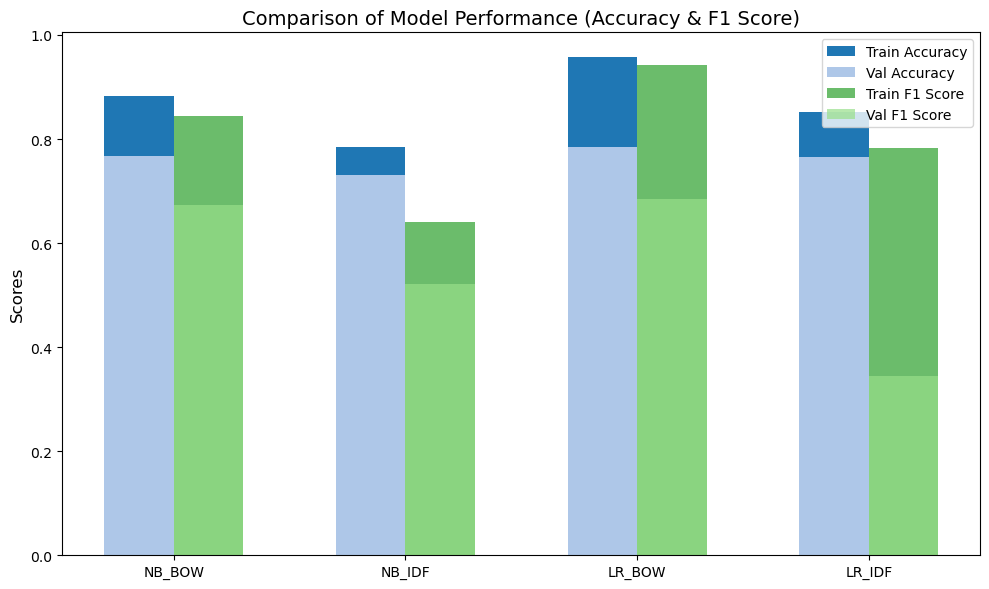

In [ ]:
model_names = results_models.index

train_accuracy = results_models['Train Accuracy']
val_accuracy = results_models['Val Accuracy']
train_f1 = results_models['Train F1 Score']
val_f1 = results_models['Val F1 Score']

bar_width = 0.3
index = np.arange(len(model_names))

fig, ax = plt.subplots(figsize=(10, 6))

bar_tra = ax.bar(index - bar_width / 2, train_accuracy, bar_width, label='Train Accuracy', color='#1F77B4' )
bar_ta = ax.bar(index - bar_width / 2, val_accuracy, bar_width, label='Val Accuracy', color='#AEC7E8')

bar_trf = ax.bar(index + bar_width / 2, train_f1, bar_width, label='Train F1 Score', alpha=0.7, color= '#2CA02C' )
bar_tf = ax.bar(index + bar_width / 2, val_f1, bar_width, label='Val F1 Score', alpha=0.7, color='#98DF8A')

ax.set_ylabel('Scores', fontsize=12)
ax.set_title('Comparison of Model Performance (Accuracy & F1 Score)', fontsize=14)

ax.set_xticks(index)
ax.set_xticklabels(model_names)

ax.legend()

plt.tight_layout()
plt.show()


The best model is... so we will do the val set with those predictions

In [ ]:
#y_pred_val =lr.predict(X_val_tfidf)


# ids = pd.DataFrame(df_val.index) 
# predict_df = pd.DataFrame(y_pred_val, columns=['label'])

# final = pd.concat([ids, predict_df], axis=1)

# final.reset_index(drop=True, inplace=True)
# final.to_csv('df_val_prediction.csv', index=False)